# Proyecto End-to-End de analítica de clientes: Riesgo, Valor y Segmentación

Este proyecto aborda de forma integral distintos retos asociados a la analítica de clientes dentro del ámbito del marketing y la gestión de la relación con el cliente.

En primer lugar, se desarrolla un pipeline completo para la predicción del abandono, con el objetivo de anticipar la pérdida de clientes y facilitar estrategias de retención basadas en datos.

En segundo lugar, se construye un modelo orientado a estimar el valor potencial o coste de vida del cliente, permitiendo evaluar su rentabilidad esperada y priorizar recursos de forma más eficiente.

Finalmente, se aplican técnicas de aprendizaje no supervisado para segmentar la base de clientes en grupos homogéneos, facilitando la definición de estrategias comerciales diferenciadas.

En conjunto, el proyecto integra clasificación, regresión y clustering dentro de un mismo marco analítico, demostrando cómo distintas técnicas de machine learning pueden complementarse para apoyar decisiones estratégicas de negocio.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prevención del abandono 

La prevención del abandono consiste en detectar aquellos clientes que podrían abandonar nuestros servicios y llevar a cabo campañas específicas de retención con el fin de evitar la pérdida. 

En esta parte del proyecto elaboraré un modelo basado en aprendizaje supervisado para la detección de clientes en esta situación. 

El conjunto de datos es relativo al abandono en una operadora de telecomunicaciones, y obtenido en el sitio de IBM Analytics. Vamos a comenzar cargando los datos:

In [36]:
df_churn = pd.read_csv('data/churn/Telco-Customer-Churn.csv', index_col=0);

df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Dividimos el conjunto de datos almacenado en en dos: **df_churn** con el 80% de las entradas, y que será utilizado en el proceso de desarrollo y validación del modelo; y **df_churn_test**, con el 20% restante. Este último dataset no será utilizado en ningún momento, para no caer en un problema de data leakage o fuga de datos

Antes de dividir el conjunto, es importante desordenar los datos, para evitar cualquier tipo de sesgo:

In [40]:
df_churn = df_churn.sample(frac=1, random_state=0)

tamaño_entrenamiento = int(len(df_churn)*0.80)

df_churn_test = df_churn.iloc[tamaño_entrenamiento:].copy()
df_churn = df_churn.iloc[:tamaño_entrenamiento].copy()

print(f'Tamaño entrenamiento: {len(df_churn)}')
print(f'Tamaño test: {len(df_churn_test)}')

Tamaño entrenamiento: 5634
Tamaño test: 1409


A partir de este momento, el proyecto se va a estructurar de la siguiente forma:

- El primer paso consiste en **explorar estos datos**. Para familiarizarnos con el problema. 

- De cara a las **transformaciones de los datos**, estos cambios se irán haciendo progresivamente. Sin embargo, todo el proceso ha de ser registrado ya que ha de ser reproducido para el tratamiento de nuevos datos. 

En este proyecto se van a aplicar funciones de preprocesamiento a un DataFrame. Estas funciones se almacenarán en una lista que se usará para creación del pipeline que implementa la secuencia de acciones de preprocesamiento sobre nuevos datos. Una vez contamos con una versión adecuada de los datos, pasaremos a scikit-learn.

Por tanto, vamos a utilizar tres listas:

* **churn_data_prep**: funciones de transformación aplicadas al DataFrame.

* **cat_cols**: nombres de las columnas que contienen valores discretos, y que han de ser tratadas como categóricas.

* **num_cols**: nombres de las columnas que han de ser tratadas como numéricas.

In [53]:
churn_data_prep = []
cat_cols = []
num_cols = []

## 1.1 Exploración de los datos

Uno de los factores clave es la distribución de las clases:

El porcentaje de muestras positivas es 27.03%


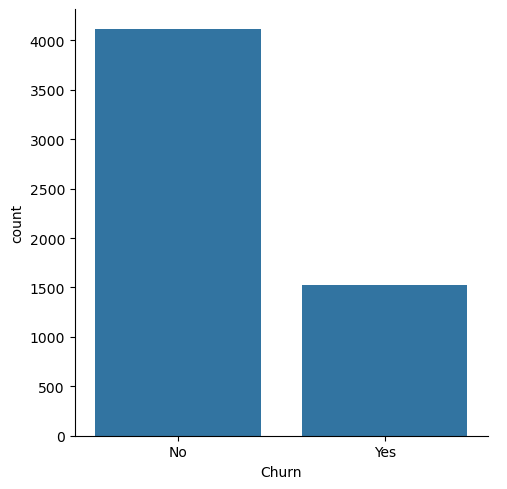

In [68]:
sns.catplot(df_churn, x='Churn', kind='count');

print(f"El porcentaje de muestras positivas es {round((sum(df_churn['Churn']=='Yes') / len(df_churn))*100,2)}%")

Se puede observar como hay muchos más registros de clientes que no han abandonado respecto a los que sí. En caso de ser así en la realidad de la empresa, estaríamos ante una muestra representativa. También se tendrá en cuenta lo que este desbalanceo puede afectar al clasificador

Para utilizar posteriormente scikit-learn, vamos a transformar nuestra variable objetivo a formato numérico.

In [73]:
df_churn['Churn'] = (df_churn['Churn']=='Yes').astype(int)
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
6296-DDOOR,Female,0,No,No,19,Yes,No,DSL,No,Yes,No,No,Yes,No,One year,No,Electronic check,58.20,1045.25,0
3680-CTHUH,Male,0,No,No,60,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),116.60,7049.5,0
4931-TRZWN,Female,0,No,No,13,Yes,No,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,71.95,923.85,0
8559-WNQZS,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.45,20.45,0
3537-HPKQT,Female,0,Yes,No,55,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),77.75,4266.4,0


In [407]:
df_churn.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int32
dtype: object

Como tenemos columnas de enteros, decimales y también Object, vamos a dividirlas por tipo y tratar cada grupo por separado.

In [76]:
dis_df_columns = df_churn.select_dtypes(exclude=np.number).columns
num_df_columns = df_churn.select_dtypes(include=np.number).columns

### Columnas discretas

En relación a estas columnas, hay dos aspectos relevantes a la hora de construir el modelo: el número de valores que puede tomar cada una; y si existe un orden entre estos valores.

4 posibilidades:

* Cuando la columna toma dos valores, la transformamos en binaria diréctamente. 
* Si el tamaño del conjunto de valores es mayor que dos, y no existe un orden, aplicaremos One Hot Encoding.
* Si existe una relación de orden, transformamos a  variables numéricas, sustituyendo cada valor por su orden. 
* Si el conjunto de valores es muy grande, exploraremos para ver si se trata de un ID o cuestiones parecidas.

In [81]:
num_values_dis_df_col = list(map(lambda col: (col,len(df_churn[col].value_counts())), dis_df_columns))
num_values_dis_df_col

[('gender', 2),
 ('Partner', 2),
 ('Dependents', 2),
 ('PhoneService', 2),
 ('MultipleLines', 3),
 ('InternetService', 3),
 ('OnlineSecurity', 3),
 ('OnlineBackup', 3),
 ('DeviceProtection', 3),
 ('TechSupport', 3),
 ('StreamingTV', 3),
 ('StreamingMovies', 3),
 ('Contract', 3),
 ('PaperlessBilling', 2),
 ('PaymentMethod', 4),
 ('TotalCharges', 5293)]

#### Caso 1: variables binarias 

In [84]:
dis_df_col_bin = list(map(lambda cv: cv[0],(filter(lambda cv: cv[1]==2,num_values_dis_df_col))))
dis_df_col_bin

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

Antes de nada, vamos a comprobar la distribución de cada una de estas variables:

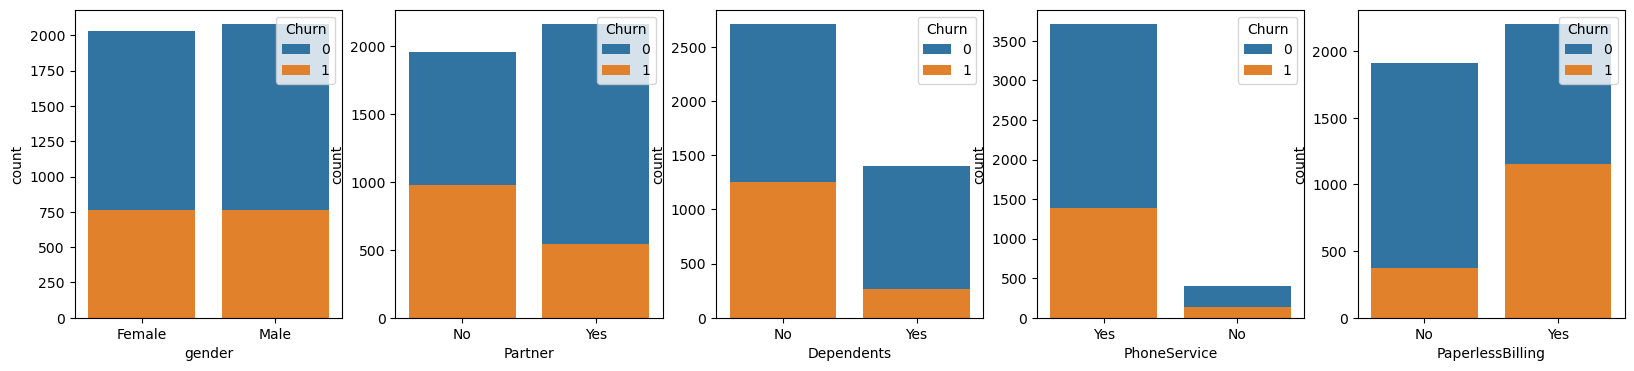

In [87]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, col in enumerate(dis_df_col_bin):
    sns.countplot(df_churn, x=col, ax=axs[i], hue='Churn', dodge=False)

Transformamos las columnas a un formato binario:

In [95]:
def churn_bin(df):
    df['gender'] = (df['gender']=='Female').apply(int)
    df['Partner'] = (df['Partner']=='Yes').apply(int)
    df['Dependents'] = (df['Dependents']=='Yes').apply(int)
    df['PhoneService'] = (df['PhoneService']=='Yes').apply(int)
    df['PaperlessBilling'] = (df['PaperlessBilling']=='Yes').apply(int)
    return df 

Aplicamos la función a los datos, y añadimos a la lista de acciones de preprocesamiento

In [97]:
churn_bin(df_churn)

churn_data_prep.append(churn_bin)

Y como estas variables han sido transformadas a binarias, se tratarán como numéricas. Añadimos a nuestra lista de variables numéricas.

In [100]:
num_cols.extend(dis_df_col_bin)

print(num_cols)

NameError: name 'num_features' is not defined

#### Caso 2: Variables discretas que toman más de dos valores 

En primer lugar, vamos a explorar la distribución de valores de cada una de ellas, y ver si se pueden considerar como ordinales.  

In [105]:
dis_df_columns_cat = list(map(lambda cv: cv[0],(filter(lambda cv: cv[1]>2 and cv[1]<5, num_values_dis_df_col))))
dis_df_columns_cat

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

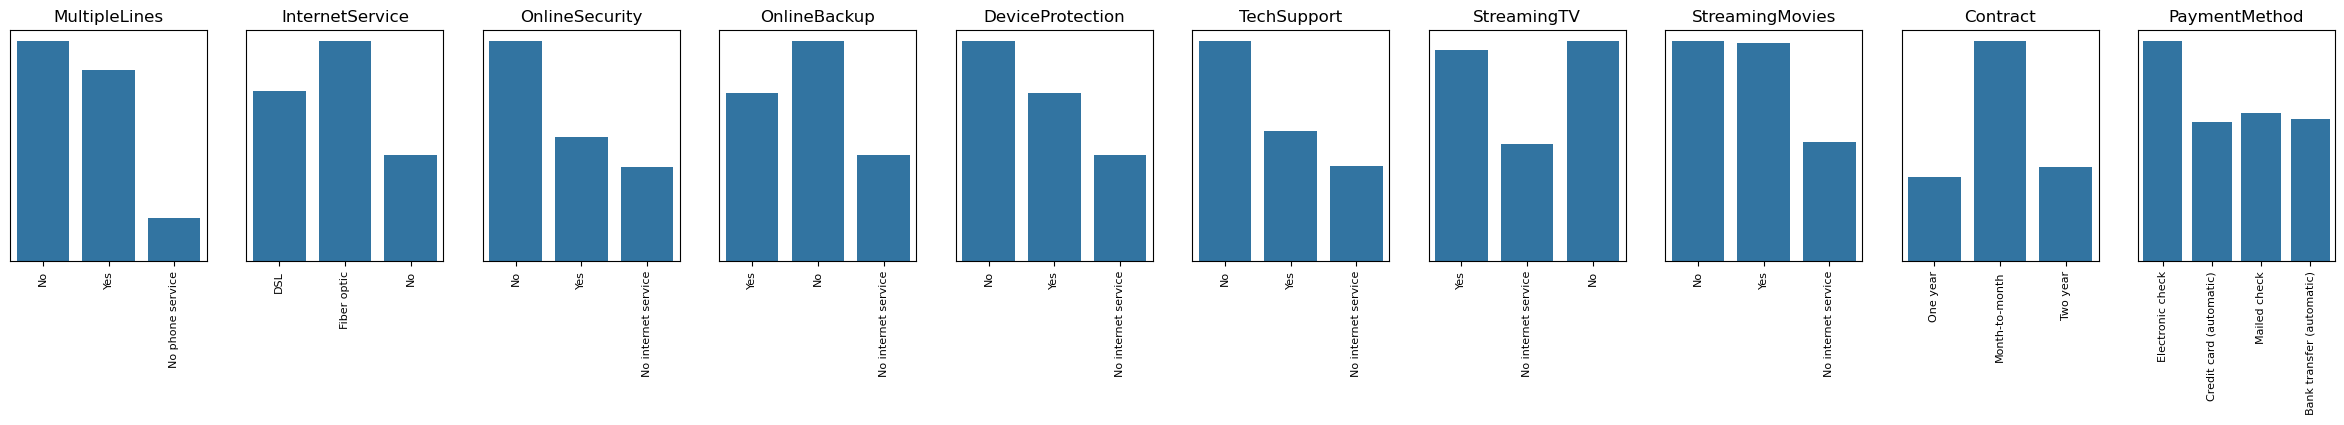

In [109]:
fig, axs = plt.subplots(1, 10, figsize=(30, 3))

for col, ax in zip(dis_df_columns_cat, axs.flatten()):
    sns.countplot(data=df_churn, x=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)

En principio, parece que todas las columnas se podrían tratar como categóricas, aunque el campo Contract se podría considerar ordinal

In [112]:
cat_cols = dis_df_columns_cat[:] 
cat_cols.remove('Contract')  
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod']

Función para convertir la columna Contract en numérica:

In [115]:
con_to_num = {'Month-to-month':1, 'One year':2, 'Two year':3}

def churn_transform_contract(df):
    df['Contract'] = df['Contract'].map(con_to_num)    
    return df

Aplicamos función y añadimos a la lista:

In [118]:
churn_transform_contract(df_churn)

churn_data_prep.append(churn_transform_contract)

Y añadimos Contract a la lista de variables numéricas

In [121]:
num_cols.append('Contract')

num_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Contract']

#### Caso 3: columnas con muchos posibles valores

La columna TotalCharges, a pesar de estar representada como un objeto, contiene datos numéricos. Debido a esto, se va a transformar en numérica

In [124]:
def churn_charges_to_num(df):
    df['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')
    return df

Aplicamos función y añadimos a la lista:

In [130]:
churn_charges_to_num(df_churn)

churn_data_prep.append(churn_charges_to_num)

Y añadimos TotalCharges a la lista de variables numéricas

In [132]:
num_cols.append('TotalCharges')

num_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Contract',
 'TotalCharges']

### Columnas numéricas 

El tratamiento de las columnas numéricas vamos a realizarlo en diversas etapas:

* Tratamiento de valores extremos. 
* Tratamiento de valores perdidos. 
* Exploración de las variables. 

#### Paso 1: Outliers 

In [141]:
df_churn[num_df_columns.to_list()+['TotalCharges']].describe(percentiles=[0.01,0.25,0.5,0.75,0.99])

,SeniorCitizen,tenure,MonthlyCharges,Churn,TotalCharges
count,5634.000000,5634.000000,5634.000000,5634.000000,5625.000000
mean,0.167554,32.117856,64.868850,0.270323,2271.272516
std,0.373503,24.543768,30.009413,0.444166,2261.518027
min,0.000000,0.000000,18.250000,0.000000,18.800000
1%,0.000000,1.000000,19.150000,0.000000,19.862000
25%,0.000000,9.000000,36.000000,0.000000,389.800000
50%,0.000000,28.000000,70.450000,0.000000,1396.000000
75%,0.000000,55.000000,89.800000,1.000000,3782.400000
99%,1.000000,72.000000,114.500000,1.000000,8020.618000
max,1.000000,72.000000,118.750000,1.000000,8684.800000


Parece que los valores mínimos y máximos no se alejan excesivamente de los rangos razonables. Por tanto, continuamos. 

#### Paso 2: Valores perdidos

In [146]:
df_churn[num_df_columns.to_list()+['TotalCharges']].isna().any()

SeniorCitizen     False
tenure            False
MonthlyCharges    False
Churn             False
TotalCharges       True
dtype: bool

Solo tenemos para TotalCharges, procederemos a tratar estos valores posteriormente en scikit-learn

#### Paso 3: Exploración

Por último, puede resultar de interés llevar a cabo una pequeña exploración de las variables numéricas para ver tanto sus distribuciones como su relación con la clase.

In [150]:
num_cols = num_cols + num_df_columns.to_list()  
num_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Contract',
 'TotalCharges',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'Churn']

Vamos a ver la distribución de nuestras variables no binarias en función de nuestra variable objetivo, para ver si detectamos algún patrón

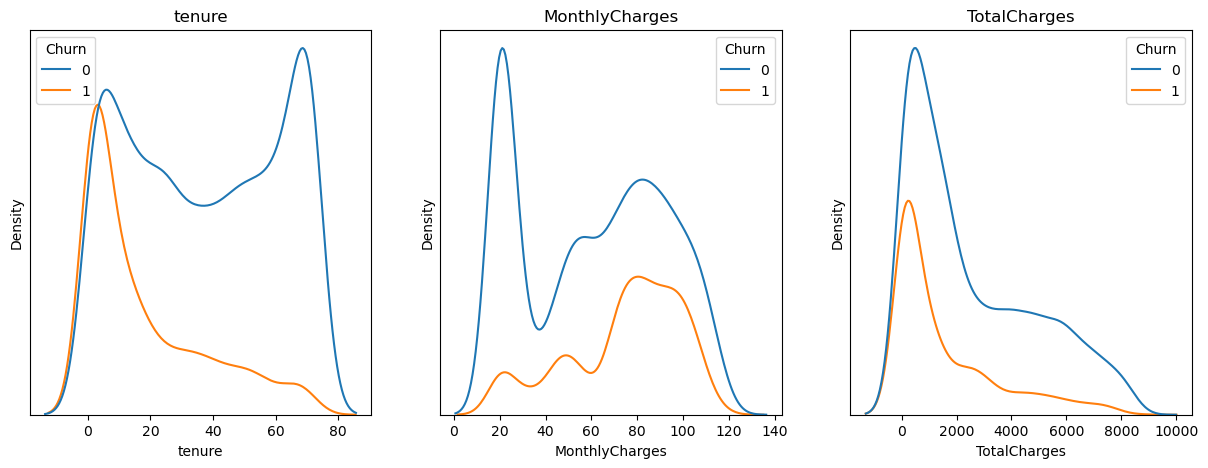

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
features = ['tenure', 'MonthlyCharges','TotalCharges']
for col, ax in enumerate(axs.flatten()):
    col_name = features[col]
    sns.kdeplot(data=df_churn, x=col_name, hue='Churn',ax=ax)
    
    ax.set_title(col_name);    
    ax.set_yticks([])

Podemos observar como conforme aumenta la antigüedad (tenure) se va reduciendo el nivel de abandono o cambio de empresa por parte de los clientes. Esto puede significar que tenemos una buena política de empresa para los clientes más 'fieles', puesto que prácticamente no hay abandonos con el paso del tiempo. El resto de variables más o menos sigue la misma distribución los clientes que han abandonado con los que permanecen

Ahora vamos a comprobar si existe correlación entre alguna de nuestras variables numéricas:

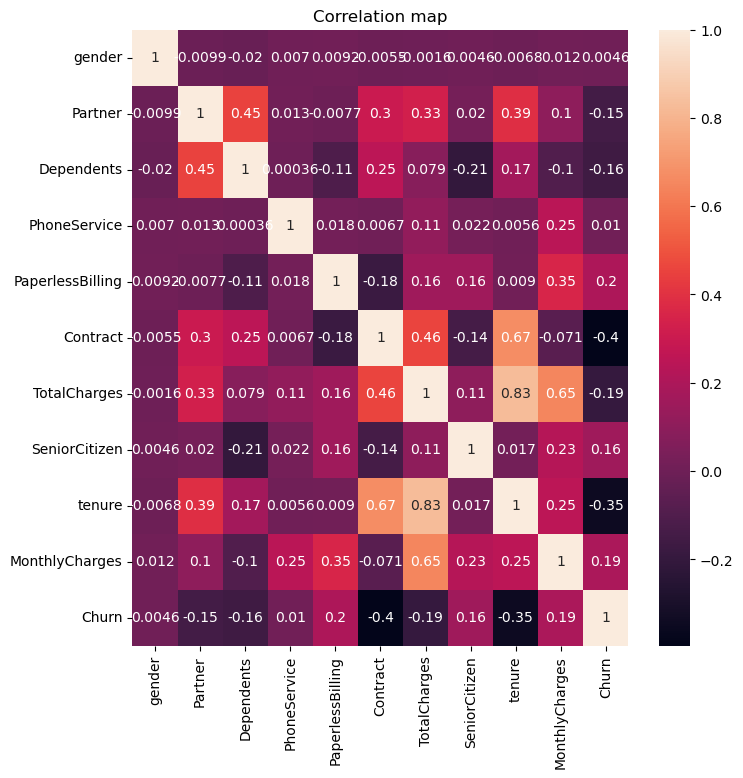

In [160]:
corr = df_churn[num_cols].corr(method='pearson')

plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True)
plt.title("Correlation map")
plt.show()

Hay una clara correlación positiva entre el tiempo que permanece un cliente en la empresa y los cargos totales. También existe cierta correlación positiva entre tenencia y contrato, normalmente si el contrato es a más tiempo, es más probable que el cliente permanezca más con nosotros, lo cual encaja totalmente con lo que habíamos visto previamente. Tambíen una correlación positiva que vemos (y totalmente lógica) es que conforme aumentan los cargos mensuales, también aumentan los cargos totales. En cuánto correlaciones negativas no hay nada muy destacable hay ligera correlación negativa entre la tasa de abandono y el contrato, lo cuál también encaja con lo visto previamente. Contrato a más tiempo suele reducir la probabilidad de abandono o cambio de empresa.

### 1.2. Preprocesamiento

Antes de continuar, vamos a eliminar nuestra variable objetivo de la lista de características numéricas

In [164]:
num_cols.remove('Churn')

La siguiente función admite como parámetros un DataFrame y una lista de funciones y las aplica sucesivamente al DataFrame. Vamos a pasarle la lista de funciones que hemos ido creando en la fase de exploración.

In [168]:
def preprocess_data(df, churn_data_prep):
    for function in churn_data_prep:
        function(df)
    return df

### 1.3. Construcción del modelo

En este punto, hemos definido un flujo de acciones de preprocesamiento, y se ha preparado un DataFrame a partir del cual se puede construir y validar el modelo

In [175]:
X = df_churn.drop('Churn',axis=1)
y = df_churn['Churn']

El primer paso en la creación del Pipeline consiste en la transformación de los datos. Comenzando por las variables numéricas:

* Se realizará imputación de valores perdidos.
* Y se normalizarán a media cero y desviación uno. Esto transforma las características numéricas para que compartan la misma escala, lo cual es vital para evitar la dominancia de características

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transformer = 	Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
num_transformer

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


Siguiendo con las transformaciones para las variables categóricas, vamos a crear un objeto que reemplace los valores perdidos por la etiqueta 'missing' y otro objeto que transforme las variables categóricas a etiquetas binarias. Para este último, fijaremos el parámetro handle_unknown='ignore' para ignorar los valores que no se han consierado en el entrenamiento, es decir, codificarlos como 0.

In [186]:
from sklearn.preprocessing import OneHotEncoder

cat_transformer = 	Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_transformer

,steps,"[('imputer', ...), ('encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,'missing'
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


Vamos a aplicar las dos secuencias anteriores de transformación sobre las características correspondientes: 

In [189]:
from sklearn.compose import ColumnTransformer

churn_trans = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

churn_trans

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


Una vez defenidas las operaciones de transformación, vamos a crear un Pipeline para aprender un modelo de regresión logística.

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

reg_log = LogisticRegression(max_iter=200);

churn_pipe_logr = 	Pipeline([
    ('prep', churn_trans),
    ('clas', reg_log)
])

churn_pipe_logr

,steps,"[('prep', ...), ('clas', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


De cara a aprender el modelo predictivo se han de ajustar varios parámetros. Por ejemplo:

* El valor utilizado para imputar valores perdidos numéricos que podrá ser 'mean' o 'median'.
* La constante de regularización para regresión logística, C, que puede ser [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000].
* El parámetro class_weight que puede ser [None, 'balanced']

Vamos a determinar cual es la mejor configuración utilizando validación cruzada de 5 subconjuntos:

In [197]:
params = {}
params['prep__num__imputer__strategy'] = ['mean', 'median']
params['clas__C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
params['clas__class_weight'] = [None, 'balanced']

GS = GridSearchCV(
    estimator = churn_pipe_logr,
    param_grid = params,
    cv = 5,
    scoring = 'roc_auc', # Elijo roc_auc porque proporciona una medida robusta de la capacidad de clasificación del modelo especialmente cuando se trabaja con clases desbalanceadas (nuestro caso)
    n_jobs = -1)

GS.fit(X,y)

print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_logr = GS.best_estimator_

Mejor score:  0.8442489475585443
Mejore configuración de parámetros:  {'clas__C': 1.0, 'clas__class_weight': None, 'prep__num__imputer__strategy': 'median'}


### 1.4. Evaluación del modelo

La siguiente función recibe nuestra variable objetivo (y) y la predicción realizada por el modelo (y_pred), y dibuja la matriz de confusión, imprimiendo por pantalla las métricas de interés. 

In [205]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def show_results(y, y_pred):
    c_mat = confusion_matrix(y, y_pred)
    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados: ")
    print(f'\taccuracy: {round(accuracy_score(y, y_pred),2)}')
    print(f'\trecall: {round(recall_score(y, y_pred),2)}')
    print(f'\tprecision: {round(precision_score(y, y_pred),2)}')
    print(f'\tf1_score: {round(f1_score(y, y_pred),2)}')
    print(f'\troc_auc: {round(roc_auc_score(y, y_pred),2)}')

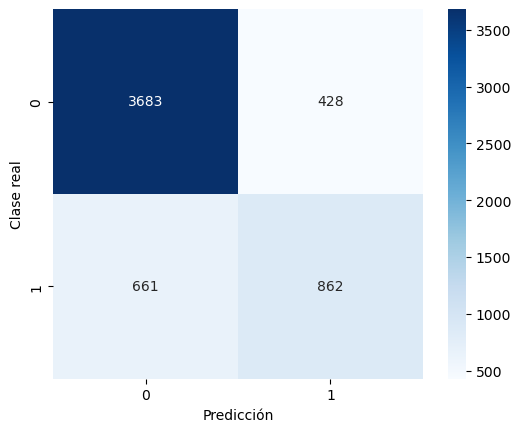

Resultados: 
	accuracy: 0.81
	recall: 0.57
	precision: 0.67
	f1_score: 0.61
	roc_auc: 0.73


In [207]:
y_pred = churn_pipe_logr.predict(X)
show_results(y, y_pred)

Con este modelo, hemos predecido 3.683 clientes que no abandonan (Verdaderos negativos) y 862 que han abandonado (verdaderos positivos). El modelo ha fallado con 1.089 clientes (un 19,32%). Cabe recalcar que el umbral de clasificación por defecto está en 0.5, es decir, si el resultado del modelo de regresión es >= 0.5 la etiqueta que se predice es 1 (abandono). Si quisieramos ser más agresivos a la hora de detectar posibles abandonos podríamos bajarla a 0.25:

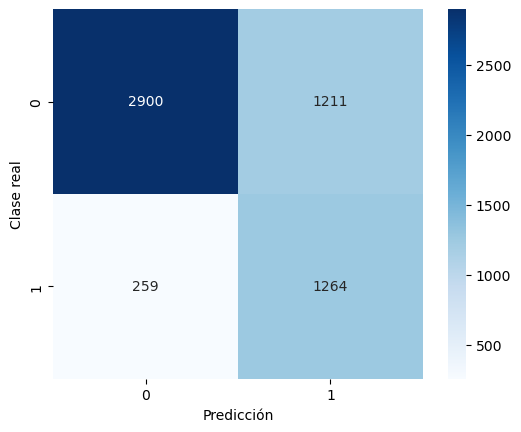

Resultados: 
	accuracy: 0.74
	recall: 0.83
	precision: 0.51
	f1_score: 0.63
	roc_auc: 0.77


In [212]:
y_prob = churn_pipe_logr.predict_proba(X)[:,1]

y_pred = y_prob >= 0.25
show_results(y, y_pred)

Vamos a dibujar la curva precision/recall. Representa el equilibrio entre la precisión (de los que predecimos abandono, cuántos son de verdad) y el recall (de todos los abandonos reales, cuántos detecté) 

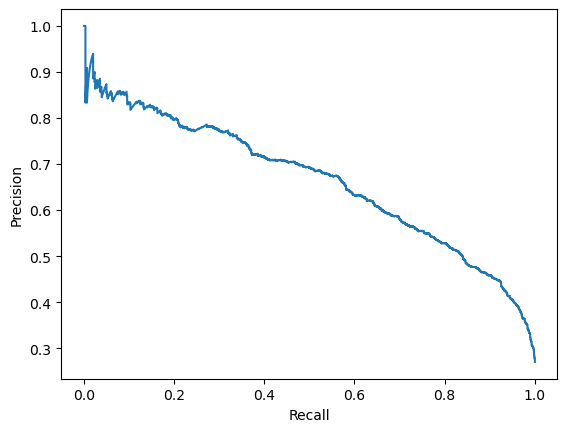

In [221]:
from sklearn.metrics import precision_recall_curve

precision,recall,thresholds = precision_recall_curve(y,y_prob)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision);

### 1.5. Validación sobre nuevos datos 

Vamos a pasar nuestro Pipeline de preprocesamiento y nuestro modelo a los datos de test

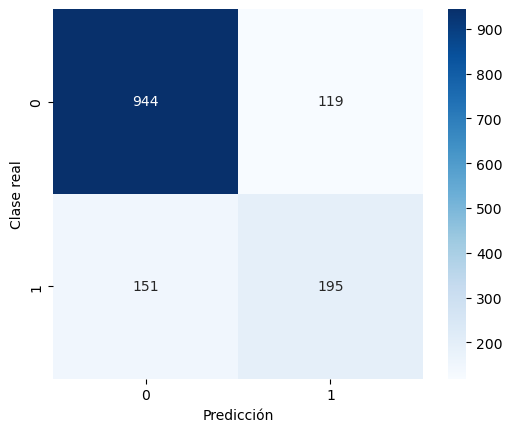

Resultados: 
	accuracy: 0.81
	recall: 0.56
	precision: 0.62
	f1_score: 0.59
	roc_auc: 0.73


In [226]:
df_churn_test_prep = preprocess_data(df_churn_test, churn_data_prep)

y_test = df_churn_test_prep['Churn'].map({'No': 0, 'Yes': 1})
X_test = df_churn_test_prep.drop('Churn', axis=1)

y_pred_test = churn_pipe_logr.predict(X_test)
show_results(y_test, y_pred_test)

### 1.6. Comparación con otros clasificadores </font>

Vamos a repetir el entrenamiento con otros clasificadores: Un árbol de decisión y una máquina de soporte vectorial. Para ver cuál nos puede ofrecer un mejor rendimiento

Mejor score:  0.8315008895871493
Mejor configuración de parámetros:  {'clas__class_weight': 'balanced', 'clas__max_depth': 5, 'prep__num__imputer__strategy': 'mean'}


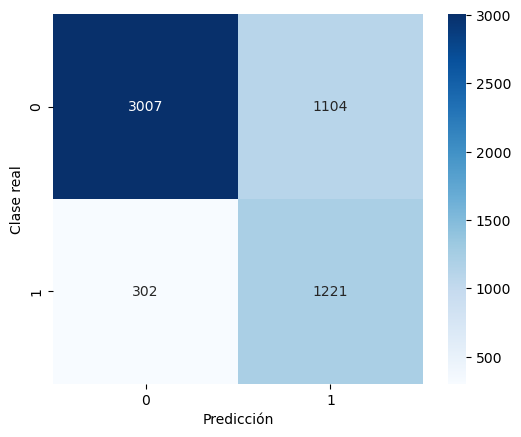

Resultados: 
	accuracy: 0.75
	recall: 0.8
	precision: 0.53
	f1_score: 0.63
	roc_auc: 0.77


In [229]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier();

churn_pipe_tree = Pipeline(steps=[('prep', churn_trans),
                                  ('clas', tree_model)])

params = {}
params['prep__num__imputer__strategy'] = ['mean', 'median']
params['clas__max_depth'] = [None, 3, 5, 7, 9]
params['clas__class_weight'] = [None, 'balanced']

GS2 = GridSearchCV(
    estimator = churn_pipe_tree,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = -1)

GS2.fit(X,y)

print("Mejor score: ", GS2.best_score_)
print("Mejor configuración de parámetros: ", GS2.best_params_)

churn_pipe_tree = GS2.best_estimator_

y_pred = churn_pipe_tree.predict(X)
show_results(y, y_pred)

Y dibujamos la curva Precision/Recall también con respecto a los nuevos datos

<Figure size 800x600 with 0 Axes>

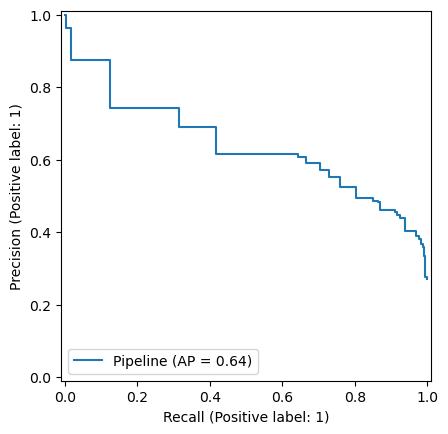

In [237]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(8,6))

PrecisionRecallDisplay.from_estimator(
    estimator=churn_pipe_tree,
    X=X,
    y=y
)
plt.show();

Procedemos ahora con el algoritmo de máquinas de soporte vectorial:

Mejor score:  0.8375986406525785
Mejor configuración de parámetros:  {'clas__C': 100, 'clas__kernel': 'linear', 'prep__num__imputer__strategy': 'median'}


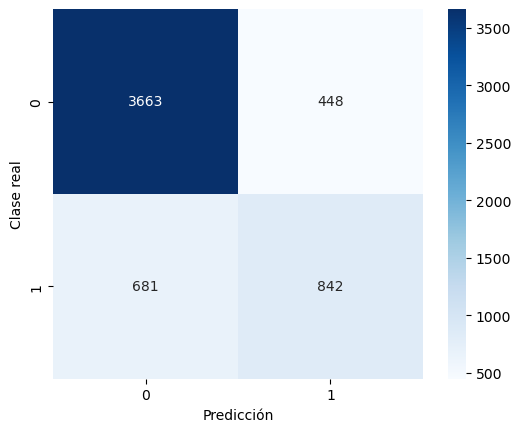

Resultados: 
	accuracy: 0.8
	recall: 0.55
	precision: 0.65
	f1_score: 0.6
	roc_auc: 0.72


In [240]:
from sklearn.svm import SVC

svm_model = SVC(probability=True);

churn_pipe_svc = Pipeline(steps=[('prep', churn_trans),
                                 ('clas', svm_model)])

params = {}
params['prep__num__imputer__strategy'] = ['mean', 'median']
params['clas__C'] = [10e-2, 1, 100]
params['clas__kernel'] = ['linear', 'rbf']

GS3 = GridSearchCV(
    estimator = churn_pipe_svc,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = -1)

GS3.fit(X,y)

print("Mejor score: ", GS3.best_score_)
print("Mejor configuración de parámetros: ", GS3.best_params_)

churn_pipe_svc = GS3.best_estimator_

y_pred = churn_pipe_svc.predict(X)
show_results(y, y_pred)

Dibujamos la curva Precision/Recall también con respecto a los nuevos datos.

<Figure size 800x600 with 0 Axes>

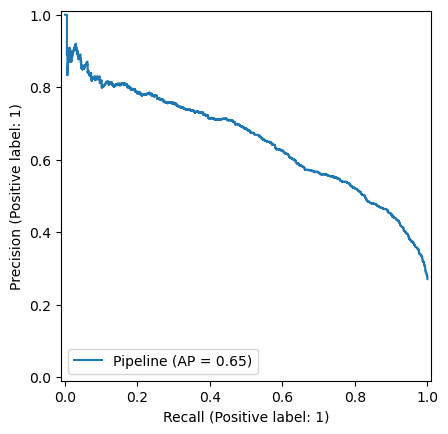

In [243]:
plt.figure(figsize=(8,6))

PrecisionRecallDisplay.from_estimator(
    estimator=churn_pipe_svc,
    X=X,
    y=y
)
plt.show()

El área bajo la curva ROC (AUC) proporciona una medida del rendimiento considerando todos los umbrales posibles. Representa la probabilidad de que el modelo asigne un score mayor a un modelo positivo que a un negativo, y es invariable con respecto a este factor. Por eso se utiliza para la comparación de modelos. 

Vamos a dibujar la curva ROC para los tres modelos y así podemos ver cuál nos convendría más. En este caso ya vamos a dibujarla con los datos de test para ver resultados reales

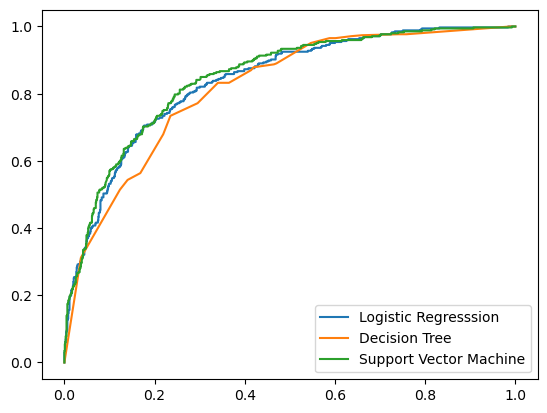

In [250]:
from sklearn.metrics import roc_curve

y_prob_logr = churn_pipe_logr.predict_proba(X_test)[:,1]
y_prob_tree = churn_pipe_tree.predict_proba(X_test)[:,1]
y_prob_svc = churn_pipe_svc.predict_proba(X_test)[:,1]

fpr_logr, tpr_logr, thr_logr = roc_curve(y_test, y_prob_logr)
fpr_tree, tpr_tree, thr_tree = roc_curve(y_test, y_prob_tree)
fpr_svc, tpr_svc, thr_svc = roc_curve(y_test, y_prob_svc)

plt.plot(fpr_logr, tpr_logr, label='Logistic Regresssion')
plt.plot(fpr_tree, tpr_tree, label='Decision Tree')
plt.plot(fpr_svc, tpr_svc, label='Support Vector Machine')
plt.legend()
plt.show()

Por último, mostrar el AUC para cada uno de los clasificadores para complementar la gráfica:

In [254]:
print("Regresión logística: ",roc_auc_score(y_test, y_prob_logr))
print("Árbol de decisión: ", roc_auc_score(y_test, y_prob_tree))
print("Máquina de vectores de soporte: ", roc_auc_score(y_test, y_prob_svc))

Regresión logística:  0.8373441399898857
Árbol de decisión:  0.8168546321622195
Máquina de vectores de soporte:  0.8465026998515489


### 1.7. Conclusión

Los tres modelos presentan una buena capacidad discriminativa (AUC > 0.81). La máquina de soporte vectorial obtiene el mayor AUC, aunque la mejora respecto a la regresión logística no es notoria. Dado que la diferencia de rendimiento es pequeña, **la regresión logística puede considerarse una alternativa preferible si se prioriza interpretabilidad y simplicidad, mientras que la SVM sería adecuada si se busca maximizar ligeramente la capacidad predictiva.**